<a href="https://colab.research.google.com/github/emmanuelkaringi/Elizabeth-PhD-Project/blob/folder-structure/notebooks/prematurity_stage_III_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Retinopathy of Prematurity Stage III Diagnosis
> Using CNNs for ROP disease diagnosis

- toc: true
- badges: true
- comments: true
- authors: Elizabeth Mutua, Dr. Bernard Shibwabo & Prof. Christoph Reich
- categories: [python, deep learning, computer vision]
- image: images/posts/retina.png
- cover: images/covers/retina.jpg


## 1. Overview

This PhD research developed an hybrid model combining the use of morphological operations and a Convolutional Neural Network (CNN) for ROP stage III disease diagnosis. Data was obtained from Kaggle database and KNH hospital database.

The modeling is performed in PyTorch. All notebooks and a PDF report are available on [Github](https://github.com/emutua09)


## 2. Background

### 2.2 Retinopathy of Prematurity (ROP)

Retinopathy of Prematurity (ROP) is an eye disease which affects newborn babies born preterm.

Babies born preterm, have their retina not fully developed and, in some cases, the blood vessels begins to grow abnormally.


### 2.3 ROP Disease Stages

**Stage I:** A whitish demarcation line is formed.

**Stage II:** Ridge line increases in width and height

**Stage III:** Abnormal growth of blood vessels, Ridgeline turns pink

**Stage IV:** Retina Detachment

**Stage V:** Blindness

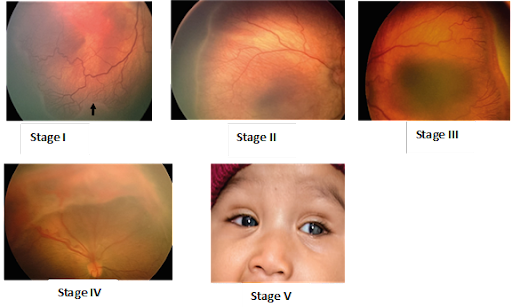


## 3. Data Preparation

The data set is available for the download at the [Kaggle database.](https://www.kaggle.com/code/solennollivier/rop-2classclassification/input?select=NewROPDataset_Sample_justtotry)

Data had been labelled.

Images were randomly selected at a ration of training=0.80, Testing =0.10, Validation =0.10.

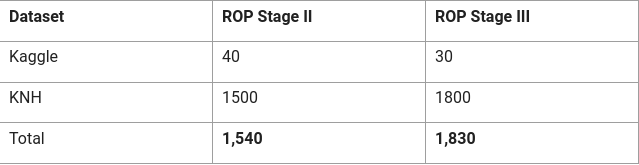

Let's start by importing the data and looking at the class distribution.

### 3.1 Image Preprocessing

#### 3.1.1 Grayscale Conversion

The conversion of images into grey scale helped to achieve uniformity of color by converting images of different color shades into grey scale. This process is aimed at increasing accuracy and clear features display.

In [ ]:
a=imread(‘image.jpg’);
b=rgb2gray(a);
imshow(b);

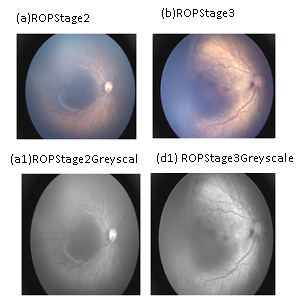

#### 3.1.2 Image Enhancement

CLAHE an improved version of the adaptive histogram equalization method was applied to reduce noise from the images and enhance the image features for better clarity.


In [ ]:
I=imread('image.jpg');
subplot(2,2,1),imshow(I);
title('ROPStageIII Original');
greenI=I(:,:,2);
subplot(1,1,1);
imshow(greenI);
title(' ROPStageIII  Green channel');
clahed = adapthisteq(greenI);
subplot(1,1,1),imshow(clahed);

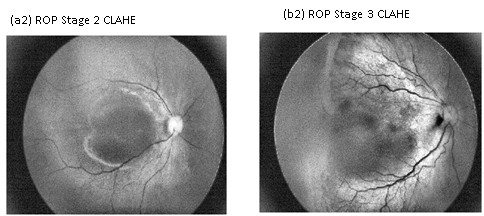

#### 3.1.3 Image Feature Extraction

Retinal vessel segmentation was done to obtain the images vessels vascular structure, their branching patterns, length, width, and angle. These are key features used for the identification of the disease stage.

In [ ]:
a = imread('image');
dim = ndims(a);
if(dim == 3)
  #convert image into greyscal
  a = rgb2gray(a);
end

#Extracting Blood Vessels
Threshold = 10;
bloodVessels = VesselExtract(a, Threshold);

#Display Blood Vessels image
figure;subplot(121);imshow(a);title('Input Image');
subplot(122);imshow(bloodVessels);title('Extracted Blood Vessels');
function bloodVessels = VesselExtract(a, threshold)

#Kirsch's Templates
h1=[5 -3 -3;     5  0 -3;     5 -3 -3]/15;
h2=[-3 -3 5;     -3  0 5;     -3 -3 5]/15;
h3=[-3 -3 -3;    5  0 -3;      5  5 -3]/15;
h4=[-3  5  5;     -3  0  5;    -3 -3 -3]/15;
h5=[-3 -3 -3;    -3  0 -3;     5  5  5]/15;
h6=[ 5  5  5;    -3  0 -3;    -3 -3 -3]/15;
h7=[-3 -3 -3;    -3  0  5;    -3  5  5]/15;
h8=[ 5  5 -3;     5  0 -3;    -3 -3 -3]/15;

#Spatial Filtering by Kirsch's Templates
t1=filter2(h1,a); t2=filter2(h2,a);t3=filter2(h3,a);
t4=filter2(h4,a);t5=filter2(h5,a);t6=filter2(h6,a);
t7=filter2(h7,a);t8=filter2(h8,a);s=size(a);
bloodVessels=zeros(s(1),s(2));
temp=zeros(1,8);

for i=1:s(1)
    for j=1:s(2)
        temp(1)=t1(i,j);temp(2)=t2(i,j);temp(3)=t3(i,j);temp(4)=t4(i,j);
        temp(5)=t5(i,j);temp(6)=t6(i,j);temp(7)=t7(i,j);temp(8)=t8(i,j);
        if(max(temp)>threshold)
            bloodVessels(i,j)=max(temp);
        end
    end
end


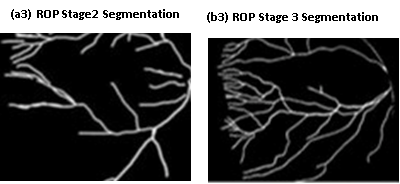

Retinopathy of Prematurity stage III is characterized by formation of a ridge line after the blood vessels have stopped growing. The model is developed to extract ridgeline marks from images and is trained to classify the presence of the disease stage using this mark of the ridge line.

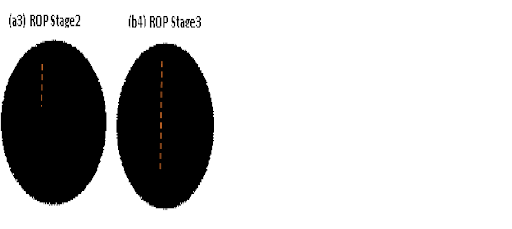

## 4. Convolutional Neural Network

The model pipeline has three phases of development:
- **Training:** -We trained the CNN model on a larger data set from KNH hospital
- **Fine-tuning:** We finetuned the model on the target data set. We used cross-validation and made modelling decisions based on the performance of the out-of-fold predictions.
- **Inference:** We aggregated predictions of the model trained on different combinations of training folds and applied test-time augmentation to further improve the performance of the model.

### 4.1 Model Training

It is complex to build a neural architecture from scratch, we customized an existing CNN architecture build to diagnose Diabetic Retinopathy with data published at [Kaggle competition](https://www.kaggle.com/c/aptos2019-blindness-detection/data) and applied transfer learning to fine tune the model using our data.

We initialized the weights from a CNN trained on DR Data and trained it using KNH data and fine-tuned it using a mix of KHN data and Kaggle database data.


#### 4.1.1 Input Image

In [ ]:
# initial data directory
data_dir_nonaug = 'dataRetinopathy'


# labeling and resizing all of data that'll be used
# 0 = ROPStage2 and 1 = ROPStage3
data_nonaug = []
categories = [' ROPStage2', ' ROPStage3']
img_size = 224


for category in categories:
    path = os.path.join(data_dir_nonaug, category1)
    class_num = categories.index(category1);for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img));
          new_array = cv2.resize(img_array, (img_size, img_size));
          data_nonaug.append([new_array, class_num]); except Exception as e:
            pass;
            print('\n Jumlah image data sebelum augmentasi: {0}'.format(len(data_nonaug)))

# Output: Jumlah image data sebelum augmentasi: 91



a_nonaug = []
b_nonaug = []

if_for features, label in data_nonaug:
    a_nonaug.append(features)
    b_nonaug.append(label)

b_nonaug = np.array(b_nonaug)

#### Data Argumentation

In [ ]:
#os should be imported from tensorflow.keras.utils, along with img_to_array and array_to_img
import load_img from keras.preprocessing.image from tensorflow.keras.utils ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=[0.85, 1.15],
    horizontal_flip = True,
    fill_mode ='nearest'
  )

# ROPStage2 augmentation
Path_ROPStage2 = os.path.join(data_dir, 'ROPStage2')
for image in os.listdir(path_ ROPStage2):
  image = load_img('dataRetinopathy/ROPStage2/0').format(img)
    x = img_to_array(image)
    x = ((1,) + x.shape + x.reshape)

  For batch in datagen.flow(x, batch_size=1, save_to_dir='dataRetinopathyaugmented/ROPStage2', save_prefix='ROPStage2', save_format='jpg'), set i = 0 as follows:
        If i is greater than 26, then i += 1; break

# ROPStage3 augmentation
Path_ROPStage3 = os.path.join(data_dir, 'ROPStage3')
for image in os.listdir(path_ ROPStage3)
    image is same to load_img('dataRETINA/ ROPStage3/0').format(img)
    x = img_to_array(image)
    x = ((1,) + x.shape + x.reshape)


    When i = 0
    for a batch in datagen.flow(x, batch_size=1,
                                save_to_dir='dataRetinopathyaugmented/ROPStage3',
                                save_prefix='ROPStage3', and save_format='jpg'),
                                the following occurs:

                                If i is more than 20, then i += 1:
                                break


#### 4.1.2 Image Resizing

In [ ]:
new_array = cv2.resize(img_array, (img_size, img_size)) plt; img_size = 224.imshow(new_array)

'n img size =', 'new_array.shape', plt.show() print img size =  (224, 224, 3)

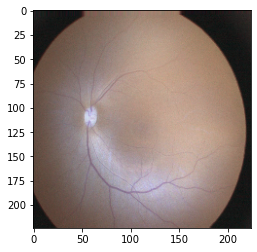

#### 4.1.3 Image Labelling

In [ ]:
# labeling and resizing all of data that'll be used.
# 0 = ROPStage2 and 1 = ROPStage3.
data = []
categories = [' ROPStage2', ' ROPStage3']
img_size = 224

os.path.join(data_dir, category) for category in categories
   classes.index(category) = class_num
   os.listdir(path), for img:
   try:
   img_array = os.path.join(path,img),cv2.imread
   new_array is equal to data.cv2.resize(img_array, (img_size, img_size)).[New_Array, class_num]
   except As an exception:
   pass
   print('\n Number of image data that will be used: 0.format(len(data)))

#Number of images that will be used: 2124

# Set Aug X and Y.
X_aug = []
y_aug = []

Label for features is added using the formulas X_aug.append(label) and Y_aug.append(label).

= np.array(y_aug)

# Data visualization of augmentation before and after.
A_nonaug, B_nonaug, C_aug, and D_aug are all equal to 0.

If y_nonaug[i] == 0 for i in range(len(y_nonaug)), then a_nonaug += 1; otherwise, b_nonaug += 1
If y_aug[i] == 0 for i in range(len(y_aug)), then c_aug += 1; otherwise, d_aug += 1

data_nonaug = np.array([a_nonaug, b_nonaug])
data_aug = np.array([c_aug, d_aug])
dataplot_aug = [data_nonaug, data_aug]
jumlah_ROPStage3_aug = [a_nonaug, c_aug]
jumlah_ROPStage2_aug = [b_nonaug, d_aug]
split_aug = ['SEBELUM', 'SETELAH']

for i in range(len(dataplot_aug)):
    positions = np.arange(2)
    plt.bar(positions, dataplot_aug[i], 0.8)
    plt.xticks(positions + 0.05, ('ROPStage 3', 'ROPStage2'))
    plt.title('Distribusi Data ROPStage3 dan Ro Pada Dataset {} Augmentasi'.format(split_aug[i]))
    print('---Dataset {0} Augmentasi---'.format(split[i]))
    plt.show()
    print('\n Jumlah data ROPStage3 pada dataset {0} augmentasi: {1}'.format(split_aug[i], jumlah_ROPStage3_aug[i]))
    print('\n Jumlah data ROPStage2 pada dataset {0} augmentasi: {1}'.format(split_aug[i], jumlah_ ROPStage2_aug[i]))
    print('\n')

#### 4.1.4 Data Splitting

In [ ]:
train_ratio = 0.80

from sklearn.model_selection import train_test_split

# determining the ratio of train-val-test data
train-val-test data using val_ratio = 0.10 and test_ratio = 0.10.

#split data into:
Train_test_split = X_train, X_test, Y_train, and Y_test(X, y, train_ratio 1, test_size 1, random_state 1)
X_val, X_test, y_val, and y_test are all equal to train_test_split(X_test, y_test, test_size=(test_ratio + val_ratio), random_state=1)

# Visualization of data distribution.
a = 0; b = 0; c = 0; d = 0; e = 0; f = 0

for i in range(len(y_train)):
  if y_train[i] == 0:
    a += 1
  else:
    b += 1

for i in range(len(y_val)):
  if y_val[i] == 0:
    c += 1
  else:
    d += 1

data1 = np.array([a, b])
data2 = np.array([c, d])
data3 = np.array([e, f])
dataplot = [data1, data2, data3]

jumlah_ROPStage3 = [a, c, e]
jumlah_ROPStage2 = [b, d, f]

split = ['Training', 'Validation', 'Test']

for i in range(len(dataplot)):
    positions = np.arange(2)
    plt.bar(positions, dataplot[i], 0.8)
    plt.xticks(positions + 0.05, ('ROPStage3', 'ROPStage2'))
    plt.title('Distribusi Data ROPStage3 dan ROPStage2 Pada {} Dataset'.format(split[i]))
    print('---{0} Dataset---'.format(split[i]))
    plt.show()
    print('\n Jumlah data ROPStage3 pada {0} dataset: {1}'.format(split[i], jumlah_ROPStage3 [i]))
    print('\n Jumlah data ROPStage2 pada {0} dataset: {1}'.format(split[i], jumlah_ROPStage2 [i]))
    print('\n')

#Jumlah data ROPStage3 pada Training dataset: 1464
#Jumlah data ROPStage2 pada Training dataset: 1232
#Jumlah data ROPStage3 pada Validation dataset: 183
#Jumlah data ROPStage2 pada Validation dataset: 154
#Jumlah data ROPStage3 pada Test dataset: 183
#Jumlah data ROPStage2 pada Test dataset: 154

#### 4.1.5 Model Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 3);

# callbacks for model
save_best_only = True,
model_checkpoint = ModelCheckpoint('best_ROPStage3_model.hdf5')

# optimizer.
opt = Adam(learning_rate=2*(10**(-5)))

Model = Sequential();

#Model blocks
Model Block 1 is.Model: add(Conv2D(64, (3, 3), activation = "relu", input_shape = X.shape[1:], padding = "same").Addition: Conv2D(64, (3,3), activation = "relu," padding = "same"
MaxPooling2D (pool_size = (2, 2), strides = 2, padding = "same") model.add
Model Block 2 is.Addition: Conv2D(128, (3,3), activation = "relu," padding = "same"
Conv2D(128, (3,3), activation = "relu," padding = "same"); model.add
model.Pool_size = (2,2), Strides = 2, Padding = "Same," MaxPooling2D, add
Model Block 3 is.Model: add(Conv2D(256, (3,3), activation = "relu," padding = "same").Model: add(Conv2D(256, (3,3), activation = "relu," padding = "same").Model: add(Conv2D(256, (3,3), activation = "relu," padding = "same").Model: add(Conv2D(256, (3,3), activation = "relu," padding = "same").Addition: MaxPooling2D (pool_size = (2,2), strides = 2)
Block 4 model is #.Model: add(Conv2D(512, (3,3), activation = "relu," padding = "same").Addition: Conv2D(512, (3,3), activation = "relu," padding = "same"
Conv2D(512, (3,3), activation = "relu," padding = "same"); model.add
model.Addition: Conv2D(512, (3,3), activation = "relu," padding = "same"
model.Pool_size = (2,2), Strides = 2, Padding = "Same," MaxPooling2D, add
Model Block 5 is.model = add(Conv2D(512, 3, 3, activation = "relu", padding = "same")).model = add(Conv2D(512, 3, 3, activation = "relu", padding = "same")).model = add(Conv2D(512, 3, 3, activation = "relu", padding = "same")).model = add(Conv2D(512, 3, 3, activation = "relu", padding = "same")).Pool_size = (2,2), Strides = 2, Padding = "Same," MaxPooling2D, add
Model with Fully Connected Layers.add(Flatten()) model.Dense(4096, activation = "relu") model added.add(Dropout(0.5)) model.Dense(4096, activation = "relu") model added.add(Dropout(0.5)) model.Dense(1000, activation = "relu") model added.Dense(2, activation = "softmax") added
Compiling the model with the following parameters: optimizer = opt, loss = "sparse_categorical_crossentropy," metrics = ["accuracy"]


# Model Training
History = model.fit(X_train, Y_train, epochs = 20, batch_size = 32, validation_data=(X_val, Y_val), callbacks = [monitor_val_acc, model_checkpoint])

- Epoch 1/20
54/54 [==============================] 1044s 19s/step, 0.6927 loss, 0.5009 accuracy, 0.6900 val_loss, and 0.5094 val_accuracy;

- Epoch 2/20
54/54 [==============================] Loss: 0.6873 Accuracy: 0.5338 750s 14s/step Val_loss: 0.6874 Val_accuracy: 0.5094

- Epoch 3/20
54/54 [==============================] 4093 steps at 77 seconds each, with a loss of 0.6714 and an accuracy of 0.5974.

- Epoch 4/20
54/54 [==============================] Loss: 0.6648 Accuracy: 0.6057 Time: 10405s Val_loss: 0.6179 Val_accuracy: 0.6651

- Epoch 5/20
54/54 [==============================]

- Epoch 6/20
54/54 - 6564s 123s/step - loss 0.6185 - accuracy 0.6516 - val_loss 0.5469 - val_accuracy 0.7123 [==============================]

- Epoch 7/20
54/54 - 815s 15s/step - loss 0.5765 - accuracy 0.6869 - val_loss 0.5652 - val_accuracy 0.6792 [==============================] Loss: 0.5017 Accuracy: 0.7387 Val_loss: 0.4230 Val_accuracy: 0.7547 754s 14s/step

- Epoch 8/20
54/54 [==============================] Epoch 9/20: 761s 14s/step, loss 0.4556, accuracy 0.7569, val_loss 0.4361, val_accuracy 0.7972
54/54 [==============================] Loss: 0.4069 Accuracy: 0.7899 Loss: 0.3187 Accuracy: 0.8019 767s 14s/step

- Epoch 10/20
54/54 [==============================] 821s 15s/step, 0.3456 loss, 0.8228 accuracy, 0.3595 value loss, and 0.8538 value accuracy

- Epoch 11/20
54/54 [==============================] 863 steps at 16 seconds each step with a loss of 0.3564 and an accuracy of 0.8122.

- Epoch 12/20
54/54 [==============================] Loss: 0.3220 Accuracy: 0.8370 Val_loss: 0.2624 Val_accuracy: 0.8491 840s 16s/step

- Epoch 13/20
54/54 [==============================] 821s 15s/step, 0.2696 loss, 0.8664 accuracy, 0.2464 value loss, and 0.8443 value accuracy

- Epoch 14/20
54/54 [==============================] Loss: 0.2160 Accuracy: 0.9064 Val_loss: 0.2583 Val_accuracy: 0.9057 819s 15s/step

- Epoch 15/20
54/54 [==============================] Epoch 16/20 54/54 - 876s 16s/step - loss 0.2232 - accuracy 0.8994 - val_loss 0.1843 - val_accuracy 0.9292 [==============================] Loss: 0.1892 Accuracy: 0.9164 Val_loss: 0.1792 Val_accuracy: 0.9340 860s 16s/step

- Epoch 17/20
54/54 [==============================] 792s 15s/step, 0.1469 loss, 0.9382 accuracy, 0.1387 val_loss, and 0.9481 val_accuracy

- Epoch 18/20
54/54 [==============================] Loss: 0.1350 Accuracy: 0.9488 Val_loss: 0.1519 Val_accuracy: 0.9340 786s 15s/step

- Epoch 19/20
54/54 [==============================] Loss: 0.0991 Accuracy: 0.9635 Val_loss: 0.1136 Val_accuracy: 0.9528 797s 15s/step

- Epoch 20/20
54/54 [==============================] 786s 15s/step, 0.1373 loss, 0.9482 accuracy, 0.1201 val_loss, and 0.9670 val_accuracy

#### 4.1.6 Model Evaluation

In [ ]:
sns import seaborn
import confusion_matrix from sklearn.metrics into matplotlib.pyplot as a plt


Summary of the model: model.summary()


"sequential_1" is the model.

=================================================================
 Convolutional Layer,              Structure,              Params #
 =================================================================
 =================================================================
 conv2d_1 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_2 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                              
 conv2d_3 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_4 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)          (None, 56, 56, 256)       295168
conv2d_6 (Conv2D)          (None, 56, 56, 256)       590080    
                                                                 
 conv2d_7 (Conv2D)          (None, 56, 56, 256)       590080    
                                                                 
 conv2d_8 (Conv2D)          (None, 56, 56, 256)       590080    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 256)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)          (None, 28, 28, 512)       1180160   
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 512)       2359808   
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 512)       2359808   
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 512)       2359808   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 512)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 512)       2359808   
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 512)       2359808   
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 512)       2359808   
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 512)       2359808
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 512)        0         
 2D)                                                             
                                                                 
 flatten_1a (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              102764544
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 1000)              4097000   
                                                                 
 dense_4 (Dense)             (None, 2)                 2002      
                                                                 
=================================================================
Param Summary: 143,669,242

Trainable: 143,669,242

Non-trainable: 0

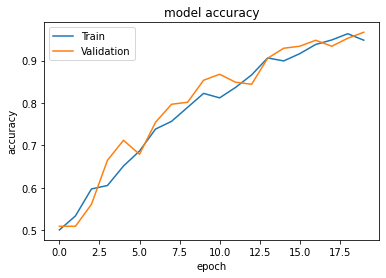

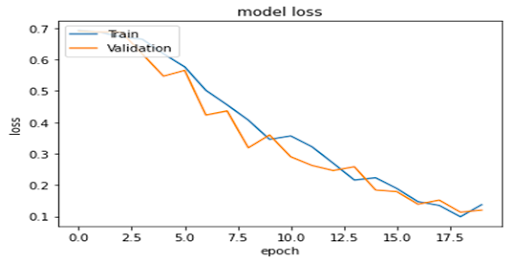